In [92]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

In [93]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [94]:
import stanza
import spacy_stanza
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish)...
INFO:stanza:File exists: /root/stanza_resources/es/default.zip.
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


Preprocesamiento de datos

* Quitar acentos y caracteres especiales
* Quitar números
* Quitar símbolos de puntuación

In [95]:
import re
import unicodedata

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # Se eliminar cualquier caracter distinto de los del regex
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [96]:
text = "texto antes del preprocesamiento en el que quitamos acentos, números y caracteres especiales"

print("preprocess text: ", preprocess_clean_text(text.lower()))

tokens = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokens)
print("Lematización de cada token:")
for token in tokens:
    print([token, token.lemma_])

preprocess text:  texto antes del preprocesamiento en el que quitamos acentos numeros y caracteres especiales
tokens: texto antes de el preprocesamiento en el que quitamos acentos numeros y caracteres especiales 
Lematización de cada token:
[texto, 'texto']
[antes, 'antes']
[de, 'de']
[el, 'el']
[preprocesamiento, 'preprocesamiento']
[en, 'en']
[el, 'el']
[que, 'que']
[quitamos, 'quitar']
[acentos, 'acento']
[numeros, 'numero']
[y, 'y']
[caracteres, 'carácter']
[especiales, 'especial']


<ipython-input-96-47f3048004fb>:5: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  tokens = nlp(preprocess_clean_text(text.lower()))
<ipython-input-96-47f3048004fb>:5: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['texto', 'antes', 'de', 'el', 'preprocesamiento', 'en', 'el', 'que', 'quitamos', 'acentos', 'numeros', 'y', 'caracteres', 'especiales']
Entities: []
  tokens = nlp(preprocess_clean_text(text.lower()))


In [97]:
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "Buenas", "Buenos días", "Buenas tardes", "Buenas noches", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?", "¿Como te llamas?", "¿Podes presentarte?", "Presentese por favor", "¿Como te puedo llamar?"],
              "responses": ["Mi nombre es TuBot", "Yo soy TuBot", "Soy TuBot y estoy para ayudarte"]
             },
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp", "¿te puedo llamar?", "Quiero llamar a la empresa", "Me gustaria contactarme por otro medio", "Me gustaría hablar con un empleado"],
              "responses": ["Podes contactarnos al siguiente <numero>", "Escríbenos al whatsapp <numero>"]
             },
            {"tag": "envios",
              "patterns": ["¿Realizan envios?", "¿Cómo me llega el paquete?", "¿Hacen envíos a domicilio?", "¿Hacen envíos a sucursales?"],
              "responses": ["Tenemos diferentes formas de envios según la zona, te recomiendo entrar a este <link>"]
             },
            {"tag": "mis_envios",
              "patterns": ["Estado de mi envio", "Cuando llega mi paquete", "Por que mi paquete todavia no llego", "Quiero que llegue mi paquete", "Necesito que llegue mi producto", "Aún no llego mi compra", "Mi compra deberia haber llegado y no llego", "LLego mi producto pero no estaba en mi casa, ¿volveran a pasar?", "No estaba en mi domicilio, ¿vuelven a pasar?", "Aún no se despacho el producto", "¿Cuando despacharan mi compra?"],
              "responses": ["Podes ver los detalles de tu envio en el siguiente link <link> allí podrás iniciar un reclamo si el envío está demorado"]
             },
            {"tag": "compra",
              "patterns": ["compra", "Tengo un problema con mi compra", "Quiero ver los detalles de mi compra", "Quiero saber el estado de mi compra"],
              "responses": ["En el siguiente link podrás encontrar tus compras y los detalles de las mismas <link>"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas"],
              "responses": ["En el siguiente link podrás encontrar los beneficios y formas de pago vigentes"]
             },
            {"tag": "stock",
              "patterns": ["Esto está disponible", "¿Tenes stock?", "¿Hay stock hoy?", "¿Como se si hay stock?", "¿El producto se encuentra disponible?"],
              "responses": ["Si el producto se encuentra publicado, hay stock del mismo"]
             },
            {"tag": "opinar",
              "patterns": ["opinar", "Quiero calificar un producto", "Como opino sobre un producto"],
              "responses": ["En el siguiente link podrás encontrar tus compras y calificar los productos <link>"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias", "Gracias por tu ayuda", "Te agradezco"],
              "responses": ["¡Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!", "Saludos", "Nos vemos", "Adios"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

In [98]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stop_words = set(stopwords.words("spanish"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []
# Por cada intención (intents) tomaremos los patrones que la caracterízan a esa intención y la transformaremos a tokens para almacenar en doc_X
# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        document = []
        for token in tokens:
          # Filtramos las stopwords
          if (token.lemma_ not in nltk_stop_words):            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [101]:
print("words:", len(words))
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)
# Tamaño del vocabulario
print("Vocabulario:", len(words))
# Cantidad de tags
print("Tags:", len(classes))

words: 67
classes: ['agradecimientos', 'bienvenida', 'compra', 'contacto', 'despedida', 'envios', 'mis_envios', 'nombre', 'opinar', 'pagos', 'stock']
doc_X: ['Hola', 'Buenas', 'Buenos días', 'Buenas tardes', 'Buenas noches', '¿Cómo estás?', '¿Qué tal?', '¿Cúal es tu nombre?', '¿Quién sos?', '¿Como te llamas?', '¿Podes presentarte?', 'Presentese por favor', '¿Como te puedo llamar?', 'contacto', 'número de contacto', 'número de teléfono', 'número de whatsapp', 'whatsapp', '¿te puedo llamar?', 'Quiero llamar a la empresa', 'Me gustaria contactarme por otro medio', 'Me gustaría hablar con un empleado', '¿Realizan envios?', '¿Cómo me llega el paquete?', '¿Hacen envíos a domicilio?', '¿Hacen envíos a sucursales?', 'Estado de mi envio', 'Cuando llega mi paquete', 'Por que mi paquete todavia no llego', 'Quiero que llegue mi paquete', 'Necesito que llegue mi producto', 'Aún no llego mi compra', 'Mi compra deberia haber llegado y no llego', 'LLego mi producto pero no estaba en mi casa, ¿volveran

In [102]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar el input en tokens y lematizar, filtrando stop words
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
      if (token.lemma_ not in nltk_stop_words):
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0

Vemos que se reduce la dimensionalidad dado que eliminamos stop words

In [103]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (67,) output: 11


In [104]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               8704      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 11)                715       
                                                                 
Total params: 17,675
Trainable params: 17,675
Non-trainable params: 0
_________________________________________________________________
None


In [105]:
hist = model.fit(x=train_X, y=train_y, epochs=300)

Epoch 1/300
2/2 [==============================] - 2s 10ms/step - loss: 2.4671 - accuracy: 0.0645
Epoch 2/300
2/2 [==============================] - 0s 9ms/step - loss: 2.3929 - accuracy: 0.0484
Epoch 3/300
2/2 [==============================] - 0s 8ms/step - loss: 2.3926 - accuracy: 0.1290
Epoch 4/300
2/2 [==============================] - 0s 8ms/step - loss: 2.3943 - accuracy: 0.0806
Epoch 5/300
2/2 [==============================] - 0s 9ms/step - loss: 2.3355 - accuracy: 0.1452
Epoch 6/300
2/2 [==============================] - 0s 9ms/step - loss: 2.3433 - accuracy: 0.1774
Epoch 7/300
2/2 [==============================] - 0s 14ms/step - loss: 2.3751 - accuracy: 0.1290
Epoch 8/300
2/2 [==============================] - 0s 11ms/step - loss: 2.3329 - accuracy: 0.1452
Epoch 9/300
2/2 [==============================] - 0s 10ms/step - loss: 2.2987 - accuracy: 0.2097
Epoch 10/300
2/2 [==============================] - 0s 9ms/step - loss: 2.3150 - accuracy: 0.1935
Epoch 11/300
2/2 [=======

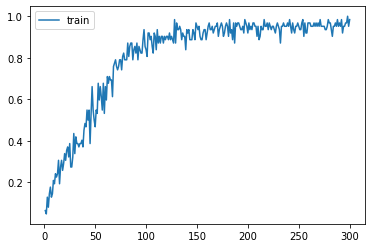

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [107]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('tu_bot_model.h5')

Testing y validación

In [108]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [109]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")

Hola!
Q: Hola!
1/1 [==============================] - 0s 64ms/step
BOT: Hola, ¿Cómo estás?
Todo bien, queria averiguar porque no me llego mi compra
Q: Todo bien, queria averiguar porque no me llego mi compra
1/1 [==============================] - 0s 36ms/step
BOT: Podes ver los detalles de tu envio en el siguiente link <link> allí podrás iniciar un reclamo si el envío está demorado
Gracias!
Q: Gracias!
1/1 [==============================] - 0s 23ms/step
BOT: ¡Por nada!, cualquier otra consulta podes escribirme
Como puedo saber si hay stock de un producto?
Q: Como puedo saber si hay stock de un producto?
1/1 [==============================] - 0s 24ms/step
BOT: Si el producto se encuentra publicado, hay stock del mismo
Tengo un problema con una compra
Q: Tengo un problema con una compra
1/1 [==============================] - 0s 39ms/step
BOT: En el siguiente link podrás encontrar tus compras y los detalles de las mismas <link>
Gracias
Q: Gracias
1/1 [==============================] - 0s 

KeyboardInterrupt: ignored